In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Transform for SVHN and MNIST (Convert MNIST to 3 channels)

In [ ]:
transform_svhn = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Loading datasets

In [ ]:
svhn_train = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_svhn)
svhn_test = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

100%|██████████| 182040794/182040794 [00:11<00:00, 15680454.96it/s]


100%|██████████| 64275384/64275384 [00:03<00:00, 20056193.56it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 142473326.31it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 16703763.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38993084.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15888681.21it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Data loaders

In [ ]:
train_loader = DataLoader(svhn_train, batch_size=64, shuffle=True)
svhn_test_loader = DataLoader(svhn_test, batch_size=64, shuffle=False)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

### Model

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = F.adaptive_avg_pool2d(out, (1, 1))
      out = out.view(out.size(0), -1)
      out = self.linear(out)
      return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)


### Define the Label Smoothing Cross Entropy Loss

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.25):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon

    def forward(self, input, target):
        num_classes = input.size(-1)
        log_preds = F.log_softmax(input, dim=-1)
        targets = torch.zeros_like(log_preds).scatter_(1, target.unsqueeze(1), 1)
        targets = (1 - self.epsilon) * targets + self.epsilon / num_classes
        loss = (-targets * log_preds).sum(dim=-1).mean()
        return loss

In [ ]:
criterion = LabelSmoothingCrossEntropy().to(device)

### Training Loop

Epoch 1/10, Loss: 2.9975
Epoch 2/10, Loss: 2.5834
Epoch 3/10, Loss: 2.5108
Epoch 4/10, Loss: 2.4671
Epoch 5/10, Loss: 2.4365
Epoch 6/10, Loss: 2.4133
Epoch 7/10, Loss: 2.3916
Epoch 8/10, Loss: 2.3754
Epoch 9/10, Loss: 2.3608
Epoch 10/10, Loss: 2.3498


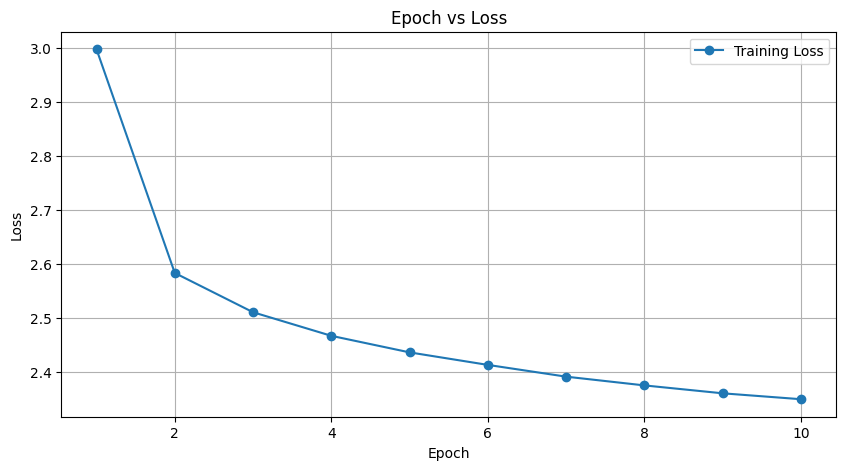

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = LabelSmoothingCrossEntropy().to(device)  # Updated to use custom loss function

num_epochs = 10  # Set the number of epochs
losses = []  # To store loss after each epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)  # Use the custom loss function
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluation function
def evaluate_model(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Evaluate on SVHN Test Set
accuracy_svhn = evaluate_model(svhn_test_loader)
print(f'Accuracy on SVHN Test Set: {accuracy_svhn}%')

# Evaluate on MNIST Test Set
accuracy_mnist = evaluate_model(mnist_test_loader)
print(f'Accuracy on MNIST Test Set: {accuracy_mnist}%')

Accuracy on SVHN Test Set: 91.94837123540258%
Accuracy on MNIST Test Set: 70.22%
